In [33]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%autoreload
import copy
import sys
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from einops import rearrange
from functorch import vmap
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm

sys.path.append("/scratch/gpfs/js5013/programs/cfilt/")
from cfilt.utils import *

In [35]:
crop = lambda x: x[3:-1, 3:-2]

In [36]:
def remove_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v

    return new_state_dict

In [37]:
class Cascade(nn.Module):
    def __init__(self, base_model, load_paths):
        super().__init__()
        self.models = [copy.deepcopy(base_model) for _ in range(len(load_paths))]
        for i, m in tqdm(enumerate(self.models), total=len(load_paths)):
            state_dict = torch.load(load_paths[i])
            state_dict = remove_data_parallel(state_dict)
            m.load_state_dict(state_dict)
        self.models = nn.ModuleList(self.models)
        self.intermediates = []

    def get_intermediates(self):
        return self.intermediates

    def forward(self, x):
        self.intermediates.clear()
        for m in self.models:
            x = m(x)
            self.intermediates.append(x)
        return x

In [5]:
ds = CDS(
    [1, 4, 8, 16, 32, 80, 160, 320, 1600],
    "jx",
    "../out/",
    normalize=True,
    transform=transforms.ToTensor(),
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [6]:
train_len = int(len(ds) * 0.95)
train_ds, test_ds = random_split(ds, (train_len, len(ds) - train_len))

dl_cfg = dict(
    batch_size=4,
    shuffle=True,
    collate_fn=unpack,
    num_workers=16,
    pin_memory=True,
)
train_dl = DataLoader(train_ds, **dl_cfg)
test_dl = DataLoader(test_ds, **dl_cfg)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [175]:
ac = nn.Sequential(
    ConvXCoder((125, 133), 1, 4, 4, 3, device),
    ConvXCoder((125, 133), 4, 1, 4, 3, device),
)

In [176]:
csc = Cascade(
    ac,
    [
        f"../models/convxcoder/{low}-{high}-3l-4c-new.pt"
        for low, high in zip(
            [1, 4, 8, 16, 32, 80, 160, 320], [4, 8, 16, 32, 80, 160, 320, 1600]
        )
    ],
).to(device)

  0%|          | 0/8 [00:00<?, ?it/s]

In [179]:
optimizer = torch.optim.Adam(csc.parameters(), lr=1e-3)
loss_fn = MS_SSIM_L1_Loss(alpha=0.7)
maploss = vmap(loss_fn, in_dims=0)

In [224]:
denormalize = lambda x, mean, std: x * std + mean
mapdenorm = vmap(denormalize, in_dims=0)

In [229]:
im = csc.get_intermediates()
torch.stack(im).shape

torch.Size([8, 4, 1, 125, 133])

In [262]:
epochs = 50
means = torch.tensor(list(ds.mean.values()))[1:].reshape(-1, 1, 1, 1, 1).to(device)
stds = torch.tensor(list(ds.std.values()))[1:].reshape(-1, 1, 1, 1, 1).to(device)
weights = torch.arange(8, 0, step=-1).to(device)
losses = []
for e in (pbar := tqdm(range(epochs))):
    csc.train()
    for i, x in enumerate(train_dl):
        optimizer.zero_grad()

        out = csc(x[0].to(device))
        im = csc.get_intermediates()

        im = torch.stack(im)  # * stds + means
        truths = torch.stack(x[1:]).to(device)  # * stds + means

        loss = (maploss(im, truths) * weights).sum()

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    pbar.set_description(f"loss: {loss.item():.2e}")

  0%|          | 0/50 [00:00<?, ?it/s]

/scratch/gpfs/js5013/.conda/envs/main/lib/python3.10/site-packages/torch/nn/functional.py:3249: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::l1_loss. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /__w/functorch/functorch/functorch/csrc/BatchedFallback.cpp:85.)
  return torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))


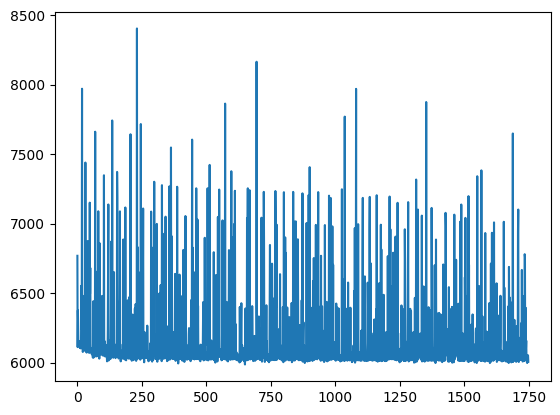

In [263]:
plt.plot(losses)

In [356]:
csc.eval()
x = next(iter(test_dl))
out = csc(x[0].to(device))
im = csc.get_intermediates()
im = torch.stack(im)  # * stds + means
truths = torch.stack(x[1:])  # .to(device) * stds + means

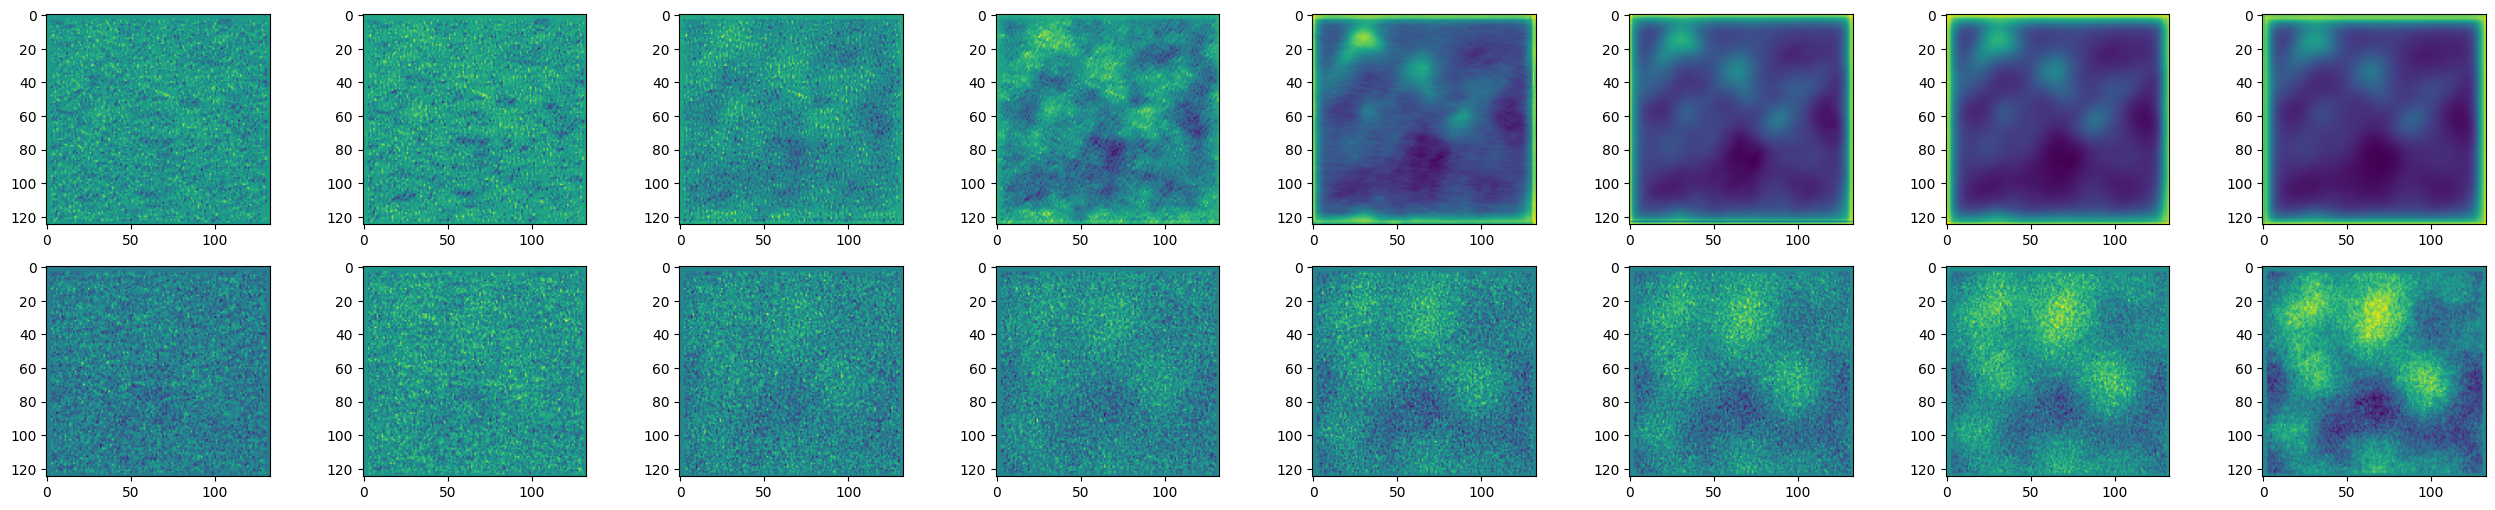

In [357]:
n = len(im)
fig, ax = plt.subplots(2, n, figsize=(4 * n, 6))
for i in range(8):
    ax[0, i].imshow(im[i][0][0].detach().cpu().numpy())
    ax[1, i].imshow(truths[i][0][0].detach().cpu().numpy())

In [8]:
csc = nn.Sequential(
    ConvXCoder((125, 133), 1, 8, 8, 3, device),
    ConvXCoder((125, 133), 8, 1, 8, 3, device),
)

In [9]:
csc.load_state_dict(
    remove_data_parallel(torch.load("../models/convxcoder/4-1600-3l-8c-new.pt"))
)

<All keys matched successfully>

In [10]:
csc.eval();

In [14]:
im = ds.images[4][10]
# rim = np.rot90(im)
tim = torch.tensor(rim.copy()).reshape(-1, 1, *im.shape).to(device)
tim = transforms.Resize((125, 133))(tim)

In [15]:
outim = csc(tim)

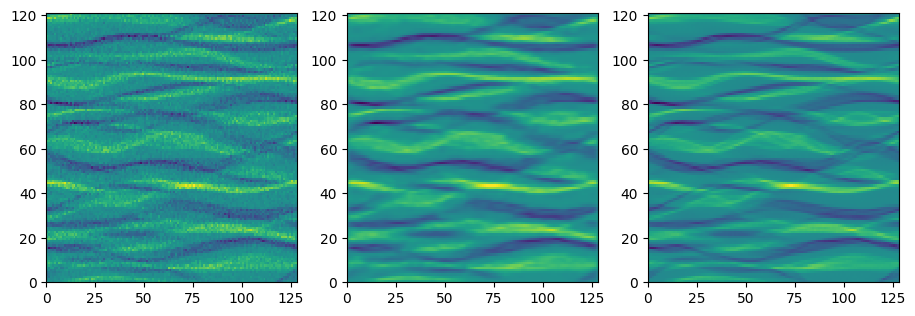

In [30]:
qplot(
    [tim, outim, torch.tensor(ds.images[1600][10]).reshape(1, 1, *im.shape)],
    lambda x: crop(x[0][0].detach().cpu().numpy()),
)

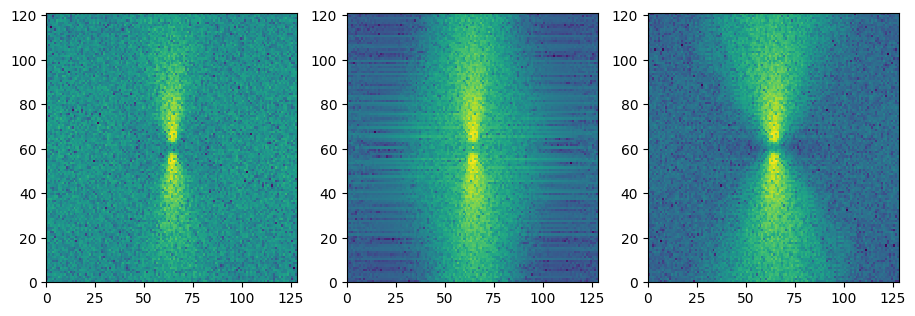

In [32]:
qplot(
    [tim, outim, torch.tensor(ds.images[1600][10]).reshape(1, 1, *im.shape)],
    lambda x: np.log(np.abs(fft2d(crop(x[0][0].detach().cpu().numpy())))),
)

# footprint

In [452]:
n1 = torch.ones((1, 1, 125, 133))
n2 = copy.deepcopy(n1)
n2[0, 0, 120, 120] = 500
o1 = csc(n1.to(device))
o2 = csc(n2.to(device))
diff = o2 - o1
msk = torch.abs(diff) > torch.finfo(torch.float32).eps

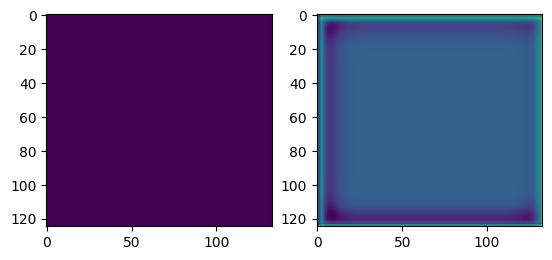

In [453]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow((n1)[0][0].numpy())
ax[1].imshow((o1)[0][0].detach().cpu().numpy())

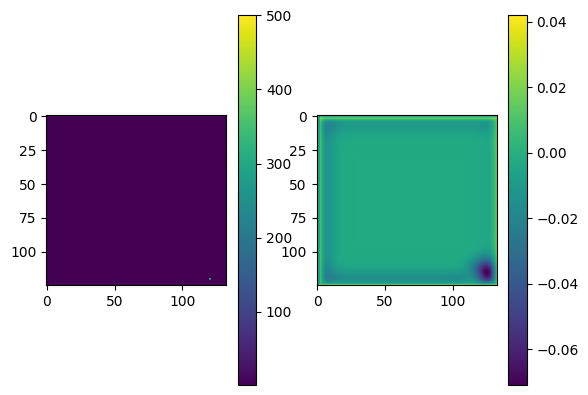

In [454]:
fig, ax = plt.subplots(1, 2)
im1 = ax[0].imshow((n2)[0][0].numpy())
plt.colorbar(im1, ax=ax[0])
im2 = ax[1].imshow((o2)[0][0].detach().cpu().numpy())
plt.colorbar(im2, ax=ax[1])

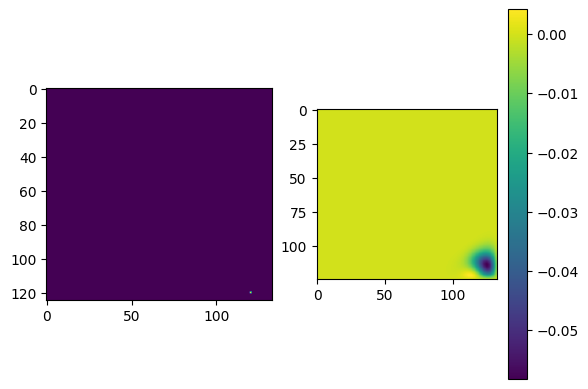

In [455]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow((n2 - n1)[0][0].numpy())
im = ax[1].imshow((diff)[0][0].detach().cpu().numpy())
plt.colorbar(im, ax=ax[1])

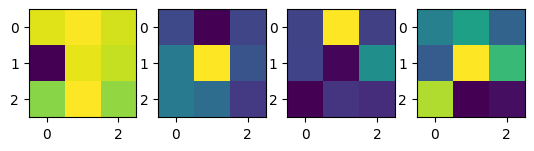

In [456]:
fig, ax = plt.subplots(1, 4)
for i, j in enumerate(
    csc.state_dict()["models.0.0.conv_in.weight"].detach().cpu().numpy()
):
    ax[i].imshow(j[0])

In [548]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
# gpr.fit(X_train, y_train)
# y_mean, y_std = gpr.predict(X, return_std=True)

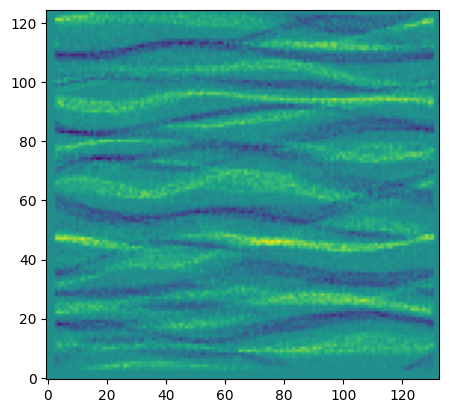

In [515]:
plt.imshow(im, origin="lower")

In [530]:
xx, yy = np.meshgrid(np.arange(133), np.arange(125))
X = np.vstack((np.ravel(xx), np.ravel(yy))).T

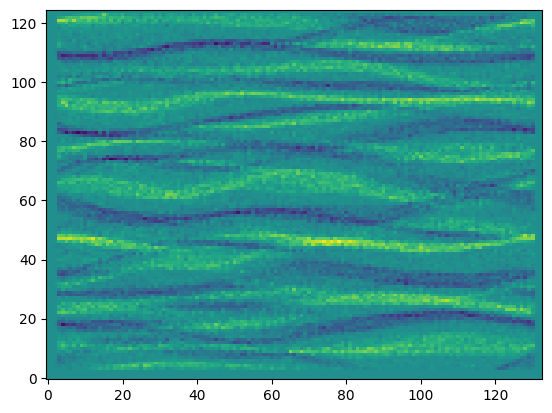

In [518]:
plt.pcolormesh(xx, yy, im)

In [549]:
ridx = np.random.choice(im.size, size=5000, replace=False)

/scratch/gpfs/js5013/.conda/envs/main/lib/python3.10/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


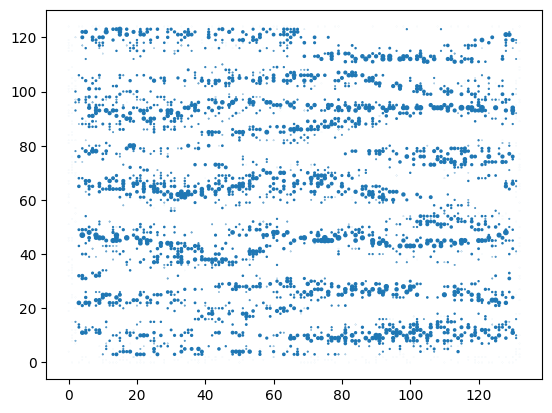

In [551]:
plt.scatter(X[ridx, 0], X[ridx, 1], np.ravel(im)[ridx])

In [550]:
gpr.fit(X[ridx], np.ravel(im)[ridx])

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))

In [552]:
y_mean, y_std = gpr.predict(X, return_std=True)

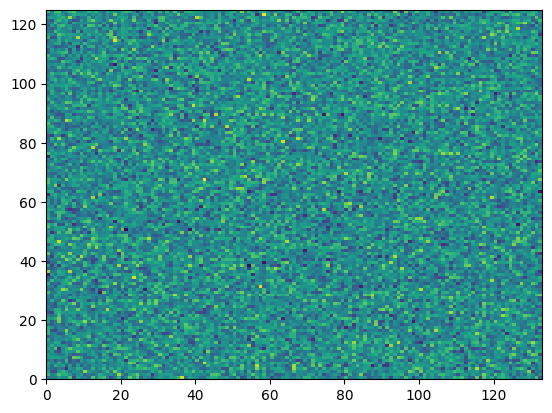

In [568]:
plt.pcolormesh(np.random.normal(y_mean, 10 * y_std).reshape((125, 133)))

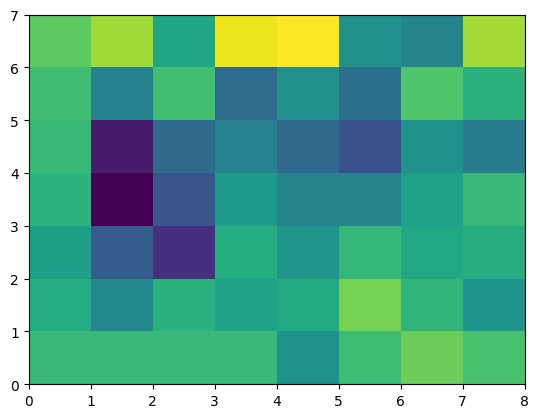

In [579]:
plt.pcolormesh(im[3:10, 2:10])